In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from distributed import LocalCluster, Client, progress

client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 


import json
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)
import numpy as np

In [2]:
def applyQuickSelection(events):
    """
    apply dijet mass and dijet dR cut (vbf production category without the inverse btage cut applied)
    """
    # apply njet and nmuons cut first
    start_len = ak.num(events.Muon.pt, axis=0).compute()

    njets = ak.num(events.Jet, axis=1)
    # nmuons = ak.num(events.Muon, axis=1)
    selection = (njets >= 2) # & (nmuons >= 2)
    events = events[selection]
    # now all events have at least two jets, apply dijet dR and dijet mass cut
    jet1 = events.Jet[:,0]
    jet2 = events.Jet[:,1]
    dijet_dR = jet1.deltaR(jet2)
    dijet = jet1+jet2
    selection = (
        (dijet_dR > 2.5) 
        & (dijet.mass > 400)
    )

    
    events = events[selection]
    end_len = ak.num(events.Muon.pt, axis=0).compute()
    print(f" {end_len} events out of {start_len} events passed the selection")

    return events
    
def getZip(events) -> ak.zip:
    """
    from events return dictionary of dimuon, muon, dijet, jet values
    we assume all events have at least two jet and two muons
    """
    jet1 = events.Jet[:,0]
    jet2 = events.Jet[:,1]
    dijet = jet1 + jet2
    muons = ak.pad_none(events.Muon, target=2)
    # mu1 = events.Muon[:,0]
    # mu2 = events.Muon[:,1]
    mu1 = muons[:,0]
    mu2 = muons[:,1]
    dimuon = mu1 + mu2
    jj_dEta = abs(jet1.eta - jet2.eta)
    jj_dPhi = abs(jet1.delta_phi(jet2))
    # dimuon = muons[:,0] + muons[:,1]
    mmj1_dEta = abs(dimuon.eta - jet1.eta)
    mmj2_dEta = abs(dimuon.eta - jet2.eta)
    mmj_min_dEta = ak.where(
        (mmj1_dEta < mmj2_dEta),
        mmj1_dEta,
        mmj2_dEta,
    )
    mmj1_dPhi = abs(dimuon.delta_phi(jet1))
    mmj2_dPhi = abs(dimuon.delta_phi(jet2))
    mmj1_dR = dimuon.delta_r(jet1)
    mmj2_dR = dimuon.delta_r(jet2)
    mmj_min_dPhi = ak.where(
        (mmj1_dPhi < mmj2_dPhi),
        mmj1_dPhi,
        mmj2_dPhi,
    )
    mmjj = dimuon + dijet
    return_dict = {
        "mu1_pt" : mu1.pt,
        "mu2_pt" : mu2.pt,
        "mu1_eta" : mu1.eta,
        "mu2_eta" : mu2.eta,
        "mu1_phi" : mu1.phi,
        "mu2_phi" : mu2.phi,
        "mu1_iso" : mu1.pfRelIso04_all,
        "mu2_iso" : mu2.pfRelIso04_all,
        "dimuon_mass" : dimuon.mass,
        "dimuon_pt" : dimuon.pt,
        "dimuon_eta" : dimuon.eta,
        "dimuon_rapidity" : dimuon.rapidity,
        "dimuon_phi" : dimuon.phi,
        "jet1_pt" : jet1.pt,
        "jet1_eta" : jet1.eta,
        "jet1_phi" : jet1.phi,
        "jet2_pt" : jet2.pt,
        "jet2_eta" : jet2.eta,
        "jet1_mass" : jet1.mass,
        "jet2_mass" : jet2.mass,
        "jj_mass" : dijet.mass,
        "jj_pt" : dijet.pt,
        "jj_eta" : dijet.eta,
        "jj_phi" : dijet.phi,
        "jj_dEta" : jj_dEta,
        "jj_dPhi":  jj_dPhi,
        "mmj1_dEta" : mmj1_dEta,
        "mmj1_dPhi" : mmj1_dPhi,
        "mmj1_dR" : mmj1_dR,
        "mmj2_dEta" : mmj2_dEta,
        "mmj2_dPhi" : mmj2_dPhi,
        "mmj2_dR" : mmj2_dR,
        "mmj_min_dEta" : mmj_min_dEta,
        "mmj_min_dPhi" : mmj_min_dPhi,
        "mmjj_pt" : mmjj.pt,
        "mmjj_eta" : mmjj.eta,
        "mmjj_phi" : mmjj.phi,
        "mmjj_mass" : mmjj.mass,
    }
    return_zip = ak.zip(return_dict).compute()
    return return_zip
    
def getHist(value, binning):
    weights = ak.ones_like(value) # None values are propagated as None here, which is useful, bc we can just override those events with zero weights
    weights = ak.fill_none(weights, value=0)
    weights = weights / ak.sum(weights)
    # print(f"number of nones: {ak.sum(ak.is_none(value))}")
    hist, edges = np.histogram(value, bins=binning, weights=weights)
    hist_w2, edges = np.histogram(value, bins=binning, weights=weights*weights)
    return hist, hist_w2  

In [3]:
input_dict = {"dy_VBF_filter_Amandeep10_6_26": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "77528b92-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "4eda6db0-6481-11ef-9fb2-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6e4216bc-6481-11ef-85aa-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "610f1cba-6481-11ef-8304-c02c12acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "850a411c-6481-11ef-b604-98080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "782fe3f2-6481-11ef-903a-0d8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "72ffc46a-6481-11ef-bb23-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5b521462-6481-11ef-85aa-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b65aa2a-6481-11ef-a246-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "83b515c6-6481-11ef-ac4f-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "72bebe3e-6481-11ef-a246-a2e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "69974358-6481-11ef-b242-f095d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "77dbccb8-6481-11ef-b765-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e4c6612-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6edd528a-6481-11ef-85aa-070a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6e4db26a-6481-11ef-b604-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "7b9cf0d4-6481-11ef-903a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5045daa4-6481-11ef-a8e2-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "8f458b46-6481-11ef-b604-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "6d2258a0-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "76b1a3b2-6481-11ef-8ed3-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6d19fe94-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "7f48f638-6481-11ef-b242-94b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "75a3e8e0-6481-11ef-b765-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6ec3cd4c-6481-11ef-b242-0a040d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "54d81230-6481-11ef-9748-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5bbaaf2c-6481-11ef-8237-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "7b409a28-6481-11ef-8ed3-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6e59124a-6481-11ef-bb23-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6ae1a44c-6481-11ef-85aa-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59f5120e-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "73252638-6481-11ef-a214-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "6d5f417a-6481-11ef-b242-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6028b73e-6481-11ef-9748-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7824eea2-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6d513508-6481-11ef-85aa-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "7a8dc204-6481-11ef-85aa-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "8386ba8c-6481-11ef-be03-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "7478cb70-6481-11ef-85aa-178ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "70f87252-6481-11ef-be03-0f8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6ef60460-6481-11ef-85aa-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6bc88ed4-6481-11ef-903a-158ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "599f8834-6481-11ef-8ce6-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ea8809c-6481-11ef-8ed3-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6e1dca14-6481-11ef-a904-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "78008cb0-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5b133d46-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6e670a1c-6481-11ef-be03-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "62e5999c-6481-11ef-b277-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "74bda2fe-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "68babf46-6481-11ef-9929-128ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "51b50068-6481-11ef-ba0b-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "75b6d69e-6481-11ef-85aa-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "727b499c-6481-11ef-8ed3-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5dafd384-6481-11ef-9e32-f9090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5adc8120-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "539b301e-6481-11ef-85aa-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "5dfe7110-6481-11ef-9580-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "705bec16-6481-11ef-be03-188ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "7749b4cc-6481-11ef-b765-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4e704764-6481-11ef-8ce6-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "18c785e0-6482-11ef-af32-168ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "7defdb12-6481-11ef-85aa-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b9089a8-6481-11ef-903a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "593b1930-6481-11ef-803a-6f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "54ffc258-6481-11ef-9fb2-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6663b5cc-6481-11ef-9a67-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59ac0adc-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "80a10bf6-6481-11ef-85aa-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5cb36c52-6481-11ef-9748-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e7a9122-6481-11ef-b604-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6af6a914-6481-11ef-a246-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "67ea61d4-6481-11ef-a8e2-96080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "70ec3136-6481-11ef-9929-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "7cefc420-6481-11ef-85aa-adb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "83a28fb4-6481-11ef-9748-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "72cb74b2-6481-11ef-be03-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "936c4dc2-6481-11ef-b8a9-8bb45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "716bd486-6481-11ef-891a-148ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "64d4d786-6481-11ef-a8e2-7c090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "68b1e8b2-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5e302aac-6481-11ef-85aa-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6fb6ec02-6481-11ef-903a-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "76b5eb2a-6481-11ef-8758-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "807cecee-6481-11ef-be03-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "72768d08-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "7917ae6c-6481-11ef-a904-17e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "859f6814-6481-11ef-be03-14e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "747277d4-6481-11ef-a904-47e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6d208778-6481-11ef-b604-2994d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c78dfb4-6481-11ef-85aa-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "718cc4d4-6481-11ef-b242-c0090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "752a3266-6481-11ef-8758-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "719fc37c-6481-11ef-a904-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "752a20dc-6481-11ef-8758-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "514c9a50-6481-11ef-9748-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "757e31b8-6481-11ef-ad21-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "81c81a24-6481-11ef-be03-5fe36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b7acb4e-6481-11ef-ac4f-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "5f92e0c4-6481-11ef-9fb2-0103fea9beef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_26"}}, "dy_VBF_filter_Amandeep10_6_32": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6d9de358-6481-11ef-aeb3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "499e6d9c-6481-11ef-8304-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "50c88954-6481-11ef-903a-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "57cf7fe6-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "69468e9a-6481-11ef-903a-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5b79d25e-6481-11ef-b604-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "53231a98-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5f87be60-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4c52867c-6481-11ef-b242-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5f87c45a-6481-11ef-be03-8bb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "4ec89f7c-6481-11ef-be03-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "68cf1e96-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "73bd6c18-6481-11ef-be05-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "55449e8c-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "50494ec8-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "67fb2ef6-6481-11ef-85aa-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5fa956a6-6481-11ef-891a-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5bf65d60-6481-11ef-903a-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "67e2ca50-6481-11ef-891a-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "641362fe-6481-11ef-891a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6981f39a-6481-11ef-9929-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "70de3126-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "5f3cb05a-6481-11ef-903a-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "7495fbb4-6481-11ef-a447-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "4bdd439e-6481-11ef-b242-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "599124ce-6481-11ef-b242-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4ee0b5f8-6481-11ef-be03-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "69817096-6481-11ef-93a0-0c890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "627ac00e-6481-11ef-a246-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "62d398d2-6481-11ef-891a-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5e9b2758-6481-11ef-b604-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "52fafbe4-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "53599ac8-6481-11ef-8304-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "f97aaf1e-6481-11ef-9c83-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "707cddd6-6481-11ef-b623-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6c53765c-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "636892ac-6481-11ef-9929-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5658eb2a-6481-11ef-85aa-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4c6dcee6-6481-11ef-8ed3-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6a1b1a16-6481-11ef-b5b1-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5c9600d6-6481-11ef-be03-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ae53ac2-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "53e6a292-6481-11ef-a904-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6c380926-6481-11ef-a3b7-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6b8ebce0-6481-11ef-9cb0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "73ad8d3e-6481-11ef-916e-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ada936a-6481-11ef-a246-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6ba78da6-6481-11ef-93a0-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ec6b436-6481-11ef-9929-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "62e660ac-6481-11ef-85aa-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4cb639e2-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "638fc660-6481-11ef-9929-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "57755728-6481-11ef-ac4f-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b0efec4-6481-11ef-ac4f-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "49cad79c-6481-11ef-8ed3-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5c75a854-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "525a46b8-6481-11ef-8ed3-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "61572712-6481-11ef-ad21-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "698161d2-6481-11ef-891a-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "5d7171fc-6481-11ef-a246-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "5aea549e-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "578c5720-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "74bba7f6-6481-11ef-b623-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6a192eea-6481-11ef-9cb0-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5a3d7c92-6481-11ef-8ed3-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "68d557fc-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "54ce15e6-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "f9b25c16-6481-11ef-807c-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6dd08f38-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "69a75f2c-6481-11ef-ac4f-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "600cc25e-6481-11ef-9929-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "63329e2c-6481-11ef-be03-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a019cf0-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5a10a8a2-6481-11ef-be03-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "4a772218-6481-11ef-bb23-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b34f9b2-6481-11ef-a4d3-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5cf1b44e-6481-11ef-b604-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4bc6330c-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "58267828-6481-11ef-9748-39b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "53f485e2-6481-11ef-9929-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6bb72f86-6481-11ef-93a0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6b9e8bb6-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "4f5caece-6481-11ef-8ed3-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "526e2598-6481-11ef-be03-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "57d0ece6-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "5b742fac-6481-11ef-803a-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5d5e0bee-6481-11ef-803a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "577f5232-6481-11ef-903a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "58234946-6481-11ef-a246-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6848e4c0-6481-11ef-891a-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c42a2aa-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a6c7700-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4d7855d6-6481-11ef-be03-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "52b2fcea-6481-11ef-9929-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6b8c393e-6481-11ef-a4d3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "53e6f076-6481-11ef-85aa-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "575d595c-6481-11ef-803a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4d437e24-6481-11ef-a246-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "576f21f0-6481-11ef-9929-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b4942fa-6481-11ef-8961-0c890d0abeef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_32"}}}

events_fromScratch = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_Amandeep10_6_26']['files'],
    schemaclass=NanoAODSchema,
).events()
events_fromScratch = applyQuickSelection(events_fromScratch)
zip_fromScratch = getZip(events_fromScratch)

/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: 

 501 events out of 1959 events passed the selection


In [4]:
rereco_input_dict = {"dy_m105_160_vbf_amc": {"files": {
    "/eos/purdue/store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/Nano25Oct2019_VBFPostMGFilter_102X_upgrade2018_realistic_v20-v1/230000/28B5DB4C-24CB-D845-96BA-34F0D8BBE067.root": {
        "object_path": "Events", 
        "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]
    },
    "/eos/purdue/store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/Nano25Oct2019_VBFPostMGFilter_102X_upgrade2018_realistic_v20-v1/60000/F74D8350-D5C4-AC4C-8F3F-1BD94DC877B1.root": {
        "object_path": "Events", 
        "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]
    },
}}}
events_rereco = NanoEventsFactory.from_root(
    rereco_input_dict['dy_m105_160_vbf_amc']['files'],
    schemaclass=NanoAODSchema,
).events()
# start_len = 1959
# start_len = 7000
start_len = 14000
events_rereco = events_rereco[:start_len]
events_rereco = applyQuickSelection(events_rereco)
zip_rereco = getZip(events_rereco)

/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


 3512 events out of 14000 events passed the selection


In [5]:
input_dict = {"dy_VBF_filter_customJMEoff": {"files": {
    "/eos/purdue/store/user/hyeonseo/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/UL18_Nano/240614_155758/0000/PPD-RunIISummer20UL18NanoAODv9-00001_307.root": {
        "object_path": "Events", "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]
    },
    "/eos/purdue/store/user/hyeonseo/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/UL18_Nano/240614_155758/0002/PPD-RunIISummer20UL18NanoAODv9-00001_2571.root": {
        "object_path": "Events", "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]
    },
}}}
events_UL = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_customJMEoff']['files'],
    schemaclass=NanoAODSchema,
).events()
# start_len = 1959
# start_len = 7000
start_len = 14000
events_UL = events_UL[:start_len]
events_UL = applyQuickSelection(events_UL)
zip_UL = getZip(events_UL)

 4847 events out of 14000 events passed the selection


In [6]:
zip_fromScratch

<Array [{mu1_pt: 51.9, mu2_pt: 31.8, ...}, ...] type='501 * {mu1_pt: ?float...'>

In [7]:
with open("plot_settings.json", "r") as file:
    plot_bins = json.load(file)

fields2plot = zip_UL.fields
for field in fields2plot:
    if field not in plot_bins.keys():
        continue
    binning = np.linspace(*plot_bins[field]["binning_linspace"])
    
    fig, ax_main = plt.subplots()
    
    hist_fromScratch, hist_fromScratch_w2 = getHist(zip_fromScratch[field], binning)
    hist_rereco, hist_rereco_w2 = getHist(zip_rereco[field], binning)
    hist_UL, hist_UL_w2 = getHist(zip_UL[field], binning)
    # jj_mass_32, edges = np.histogram(dijet_32.mass, bins=binning, weights=)
    # jj_mass_rereco, edges = np.histogram(dijet_rereco.mass, bins=binning, weights=)
    
    
        
    hep.histplot(hist_fromScratch, bins=binning, 
             histtype='errorbar', 
            label="from Amandeep 10_6_32", 
             xerr=True, 
             yerr=np.sqrt(hist_fromScratch_w2),
            color = "blue",
            ax=ax_main
    )
    hep.histplot(hist_rereco, bins=binning, 
             histtype='errorbar', 
            label="from RERECO sample", 
             xerr=True, 
             yerr=np.sqrt(hist_rereco_w2),
            color = "red",
            ax=ax_main
    )
    hep.histplot(hist_UL, bins=binning, 
             histtype='errorbar', 
            label="from UL sample", 
             xerr=True, 
             yerr=np.sqrt(hist_UL_w2),
            color = "black",
            ax=ax_main
    )
    
    ax_main.set_xlabel( plot_bins[field].get("xlabel"))
    plt.title(f"{field} distribution of privately produced samples")
    plt.legend(loc="upper right")
    # plt.show()
    save_full_path = f"./quick_plots/PrivateProd_{field}.pdf"
    plt.savefig(save_full_path)
    plt.clf()

/tmp/ipykernel_525643/2246645993.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax_main = plt.subplots()


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [2]:
input_dict = {"dy_VBF_filter_Amandeep10_6_26": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "77528b92-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "4eda6db0-6481-11ef-9fb2-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6e4216bc-6481-11ef-85aa-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "610f1cba-6481-11ef-8304-c02c12acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "850a411c-6481-11ef-b604-98080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "782fe3f2-6481-11ef-903a-0d8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "72ffc46a-6481-11ef-bb23-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5b521462-6481-11ef-85aa-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b65aa2a-6481-11ef-a246-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "83b515c6-6481-11ef-ac4f-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "72bebe3e-6481-11ef-a246-a2e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "69974358-6481-11ef-b242-f095d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "77dbccb8-6481-11ef-b765-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e4c6612-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6edd528a-6481-11ef-85aa-070a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6e4db26a-6481-11ef-b604-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "7b9cf0d4-6481-11ef-903a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5045daa4-6481-11ef-a8e2-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "8f458b46-6481-11ef-b604-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "6d2258a0-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "76b1a3b2-6481-11ef-8ed3-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6d19fe94-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "7f48f638-6481-11ef-b242-94b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "75a3e8e0-6481-11ef-b765-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6ec3cd4c-6481-11ef-b242-0a040d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "54d81230-6481-11ef-9748-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5bbaaf2c-6481-11ef-8237-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "7b409a28-6481-11ef-8ed3-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6e59124a-6481-11ef-bb23-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6ae1a44c-6481-11ef-85aa-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59f5120e-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "73252638-6481-11ef-a214-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "6d5f417a-6481-11ef-b242-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6028b73e-6481-11ef-9748-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7824eea2-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6d513508-6481-11ef-85aa-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "7a8dc204-6481-11ef-85aa-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "8386ba8c-6481-11ef-be03-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "7478cb70-6481-11ef-85aa-178ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "70f87252-6481-11ef-be03-0f8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6ef60460-6481-11ef-85aa-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6bc88ed4-6481-11ef-903a-158ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "599f8834-6481-11ef-8ce6-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ea8809c-6481-11ef-8ed3-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6e1dca14-6481-11ef-a904-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "78008cb0-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5b133d46-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6e670a1c-6481-11ef-be03-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "62e5999c-6481-11ef-b277-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "74bda2fe-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "68babf46-6481-11ef-9929-128ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "51b50068-6481-11ef-ba0b-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "75b6d69e-6481-11ef-85aa-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "727b499c-6481-11ef-8ed3-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5dafd384-6481-11ef-9e32-f9090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5adc8120-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "539b301e-6481-11ef-85aa-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "5dfe7110-6481-11ef-9580-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "705bec16-6481-11ef-be03-188ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "7749b4cc-6481-11ef-b765-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4e704764-6481-11ef-8ce6-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "18c785e0-6482-11ef-af32-168ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "7defdb12-6481-11ef-85aa-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b9089a8-6481-11ef-903a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "593b1930-6481-11ef-803a-6f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "54ffc258-6481-11ef-9fb2-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6663b5cc-6481-11ef-9a67-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59ac0adc-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "80a10bf6-6481-11ef-85aa-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5cb36c52-6481-11ef-9748-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e7a9122-6481-11ef-b604-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6af6a914-6481-11ef-a246-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "67ea61d4-6481-11ef-a8e2-96080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "70ec3136-6481-11ef-9929-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "7cefc420-6481-11ef-85aa-adb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "83a28fb4-6481-11ef-9748-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "72cb74b2-6481-11ef-be03-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "936c4dc2-6481-11ef-b8a9-8bb45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "716bd486-6481-11ef-891a-148ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "64d4d786-6481-11ef-a8e2-7c090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "68b1e8b2-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5e302aac-6481-11ef-85aa-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6fb6ec02-6481-11ef-903a-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "76b5eb2a-6481-11ef-8758-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "807cecee-6481-11ef-be03-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "72768d08-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "7917ae6c-6481-11ef-a904-17e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "859f6814-6481-11ef-be03-14e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "747277d4-6481-11ef-a904-47e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6d208778-6481-11ef-b604-2994d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c78dfb4-6481-11ef-85aa-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "718cc4d4-6481-11ef-b242-c0090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "752a3266-6481-11ef-8758-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "719fc37c-6481-11ef-a904-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "752a20dc-6481-11ef-8758-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "514c9a50-6481-11ef-9748-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "757e31b8-6481-11ef-ad21-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "81c81a24-6481-11ef-be03-5fe36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b7acb4e-6481-11ef-ac4f-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "5f92e0c4-6481-11ef-9fb2-0103fea9beef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_26"}}, "dy_VBF_filter_Amandeep10_6_32": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6d9de358-6481-11ef-aeb3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "499e6d9c-6481-11ef-8304-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "50c88954-6481-11ef-903a-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "57cf7fe6-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "69468e9a-6481-11ef-903a-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5b79d25e-6481-11ef-b604-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "53231a98-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5f87be60-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4c52867c-6481-11ef-b242-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5f87c45a-6481-11ef-be03-8bb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "4ec89f7c-6481-11ef-be03-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "68cf1e96-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "73bd6c18-6481-11ef-be05-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "55449e8c-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "50494ec8-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "67fb2ef6-6481-11ef-85aa-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5fa956a6-6481-11ef-891a-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5bf65d60-6481-11ef-903a-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "67e2ca50-6481-11ef-891a-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "641362fe-6481-11ef-891a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6981f39a-6481-11ef-9929-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "70de3126-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "5f3cb05a-6481-11ef-903a-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "7495fbb4-6481-11ef-a447-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "4bdd439e-6481-11ef-b242-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "599124ce-6481-11ef-b242-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4ee0b5f8-6481-11ef-be03-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "69817096-6481-11ef-93a0-0c890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "627ac00e-6481-11ef-a246-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "62d398d2-6481-11ef-891a-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5e9b2758-6481-11ef-b604-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "52fafbe4-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "53599ac8-6481-11ef-8304-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "f97aaf1e-6481-11ef-9c83-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "707cddd6-6481-11ef-b623-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6c53765c-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "636892ac-6481-11ef-9929-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5658eb2a-6481-11ef-85aa-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4c6dcee6-6481-11ef-8ed3-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6a1b1a16-6481-11ef-b5b1-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5c9600d6-6481-11ef-be03-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ae53ac2-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "53e6a292-6481-11ef-a904-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6c380926-6481-11ef-a3b7-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6b8ebce0-6481-11ef-9cb0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "73ad8d3e-6481-11ef-916e-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ada936a-6481-11ef-a246-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6ba78da6-6481-11ef-93a0-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ec6b436-6481-11ef-9929-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "62e660ac-6481-11ef-85aa-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4cb639e2-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "638fc660-6481-11ef-9929-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "57755728-6481-11ef-ac4f-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b0efec4-6481-11ef-ac4f-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "49cad79c-6481-11ef-8ed3-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5c75a854-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "525a46b8-6481-11ef-8ed3-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "61572712-6481-11ef-ad21-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "698161d2-6481-11ef-891a-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "5d7171fc-6481-11ef-a246-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "5aea549e-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "578c5720-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "74bba7f6-6481-11ef-b623-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6a192eea-6481-11ef-9cb0-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5a3d7c92-6481-11ef-8ed3-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "68d557fc-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "54ce15e6-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "f9b25c16-6481-11ef-807c-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6dd08f38-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "69a75f2c-6481-11ef-ac4f-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "600cc25e-6481-11ef-9929-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "63329e2c-6481-11ef-be03-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a019cf0-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5a10a8a2-6481-11ef-be03-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "4a772218-6481-11ef-bb23-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b34f9b2-6481-11ef-a4d3-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5cf1b44e-6481-11ef-b604-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4bc6330c-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "58267828-6481-11ef-9748-39b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "53f485e2-6481-11ef-9929-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6bb72f86-6481-11ef-93a0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6b9e8bb6-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "4f5caece-6481-11ef-8ed3-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "526e2598-6481-11ef-be03-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "57d0ece6-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "5b742fac-6481-11ef-803a-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5d5e0bee-6481-11ef-803a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "577f5232-6481-11ef-903a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "58234946-6481-11ef-a246-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6848e4c0-6481-11ef-891a-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c42a2aa-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a6c7700-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4d7855d6-6481-11ef-be03-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "52b2fcea-6481-11ef-9929-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6b8c393e-6481-11ef-a4d3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "53e6f076-6481-11ef-85aa-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "575d595c-6481-11ef-803a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4d437e24-6481-11ef-a246-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "576f21f0-6481-11ef-9929-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b4942fa-6481-11ef-8961-0c890d0abeef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_32"}}}

events_26 = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_Amandeep10_6_26']['files'],
    schemaclass=NanoAODSchema,
).events()

events_32 = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_Amandeep10_6_32']['files'],
    schemaclass=NanoAODSchema,
).events()

/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: 

In [3]:
print(ak.num(events_26.Muon.pt, axis=0).compute())
print(ak.num(events_32.Muon.pt, axis=0).compute())

1959
1959


In [4]:
events_26.Jet.pt.compute()

/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/work/users/yun79/coffea_prototype/coffea/src/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import wa

<Array [[65.9, 42.2, 40.4, 19, 15.5], ...] type='1959 * var * float32[param...'>

In [13]:
import vector
vector.register_awkward()

input_dict = {"dy_VBF_filter_Amandeep10_6_26": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "77528b92-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "4eda6db0-6481-11ef-9fb2-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6e4216bc-6481-11ef-85aa-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "610f1cba-6481-11ef-8304-c02c12acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "850a411c-6481-11ef-b604-98080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "782fe3f2-6481-11ef-903a-0d8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "72ffc46a-6481-11ef-bb23-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5b521462-6481-11ef-85aa-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b65aa2a-6481-11ef-a246-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "83b515c6-6481-11ef-ac4f-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "72bebe3e-6481-11ef-a246-a2e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "69974358-6481-11ef-b242-f095d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "77dbccb8-6481-11ef-b765-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e4c6612-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6edd528a-6481-11ef-85aa-070a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6e4db26a-6481-11ef-b604-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "7b9cf0d4-6481-11ef-903a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5045daa4-6481-11ef-a8e2-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "8f458b46-6481-11ef-b604-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "6d2258a0-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "76b1a3b2-6481-11ef-8ed3-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "6d19fe94-6481-11ef-9929-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "7f48f638-6481-11ef-b242-94b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "75a3e8e0-6481-11ef-b765-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6ec3cd4c-6481-11ef-b242-0a040d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "54d81230-6481-11ef-9748-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5bbaaf2c-6481-11ef-8237-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "7b409a28-6481-11ef-8ed3-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6e59124a-6481-11ef-bb23-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6ae1a44c-6481-11ef-85aa-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59f5120e-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "73252638-6481-11ef-a214-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "6d5f417a-6481-11ef-b242-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "6028b73e-6481-11ef-9748-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7824eea2-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6d513508-6481-11ef-85aa-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "7a8dc204-6481-11ef-85aa-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "8386ba8c-6481-11ef-be03-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "7478cb70-6481-11ef-85aa-178ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "70f87252-6481-11ef-be03-0f8ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6ef60460-6481-11ef-85aa-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6bc88ed4-6481-11ef-903a-158ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "599f8834-6481-11ef-8ce6-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ea8809c-6481-11ef-8ed3-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6e1dca14-6481-11ef-a904-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "78008cb0-6481-11ef-aeb3-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5b133d46-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6e670a1c-6481-11ef-be03-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "62e5999c-6481-11ef-b277-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "74bda2fe-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "68babf46-6481-11ef-9929-128ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "51b50068-6481-11ef-ba0b-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "75b6d69e-6481-11ef-85aa-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "727b499c-6481-11ef-8ed3-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5dafd384-6481-11ef-9e32-f9090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5adc8120-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "539b301e-6481-11ef-85aa-020013acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "5dfe7110-6481-11ef-9580-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "705bec16-6481-11ef-be03-188ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "7749b4cc-6481-11ef-b765-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4e704764-6481-11ef-8ce6-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "18c785e0-6482-11ef-af32-168ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "7defdb12-6481-11ef-85aa-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b9089a8-6481-11ef-903a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "593b1930-6481-11ef-803a-6f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "54ffc258-6481-11ef-9fb2-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6663b5cc-6481-11ef-9a67-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "59ac0adc-6481-11ef-a8e2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "80a10bf6-6481-11ef-85aa-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5cb36c52-6481-11ef-9748-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "6e7a9122-6481-11ef-b604-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6af6a914-6481-11ef-a246-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "67ea61d4-6481-11ef-a8e2-96080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "70ec3136-6481-11ef-9929-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "7cefc420-6481-11ef-85aa-adb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "83a28fb4-6481-11ef-9748-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "72cb74b2-6481-11ef-be03-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "936c4dc2-6481-11ef-b8a9-8bb45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "716bd486-6481-11ef-891a-148ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "64d4d786-6481-11ef-a8e2-7c090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "68b1e8b2-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5e302aac-6481-11ef-85aa-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "6fb6ec02-6481-11ef-903a-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "76b5eb2a-6481-11ef-8758-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "807cecee-6481-11ef-be03-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "72768d08-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "7917ae6c-6481-11ef-a904-17e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "859f6814-6481-11ef-be03-14e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "747277d4-6481-11ef-a904-47e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6d208778-6481-11ef-b604-2994d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c78dfb4-6481-11ef-85aa-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "718cc4d4-6481-11ef-b242-c0090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "752a3266-6481-11ef-8758-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "719fc37c-6481-11ef-a904-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "752a20dc-6481-11ef-8758-76870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "514c9a50-6481-11ef-9748-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "757e31b8-6481-11ef-ad21-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "81c81a24-6481-11ef-be03-5fe36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "7b7acb4e-6481-11ef-ac4f-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_26/240827_142843/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "5f92e0c4-6481-11ef-9fb2-0103fea9beef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_26"}}, "dy_VBF_filter_Amandeep10_6_32": {"files": {"/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_1.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6d9de358-6481-11ef-aeb3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_10.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "499e6d9c-6481-11ef-8304-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_100.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "50c88954-6481-11ef-903a-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_11.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "57cf7fe6-6481-11ef-a904-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_12.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "69468e9a-6481-11ef-903a-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_13.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5b79d25e-6481-11ef-b604-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_14.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "53231a98-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_15.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5f87be60-6481-11ef-be03-2c94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_16.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4c52867c-6481-11ef-b242-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_17.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5f87c45a-6481-11ef-be03-8bb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_18.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "4ec89f7c-6481-11ef-be03-8f870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_19.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "68cf1e96-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_2.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "73bd6c18-6481-11ef-be05-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_20.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "55449e8c-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_21.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "50494ec8-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_22.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "67fb2ef6-6481-11ef-85aa-11090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_23.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5fa956a6-6481-11ef-891a-2894d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_24.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "5bf65d60-6481-11ef-903a-0f0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_25.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "67e2ca50-6481-11ef-891a-abb55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_26.root": {"object_path": "Events", "steps": [[0, 29]], "num_entries": 29, "uuid": "641362fe-6481-11ef-891a-2b94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_27.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6981f39a-6481-11ef-9929-42b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_28.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "70de3126-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_29.root": {"object_path": "Events", "steps": [[0, 31]], "num_entries": 31, "uuid": "5f3cb05a-6481-11ef-903a-9de36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_3.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "7495fbb4-6481-11ef-a447-64870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_30.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "4bdd439e-6481-11ef-b242-86870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_31.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "599124ce-6481-11ef-b242-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_32.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4ee0b5f8-6481-11ef-be03-91870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_33.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "69817096-6481-11ef-93a0-0c890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_34.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "627ac00e-6481-11ef-a246-f2080d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_35.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "62d398d2-6481-11ef-891a-f082e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_36.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5e9b2758-6481-11ef-b604-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_37.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "52fafbe4-6481-11ef-9fb2-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_38.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "53599ac8-6481-11ef-8304-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_39.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "f97aaf1e-6481-11ef-9c83-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_4.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "707cddd6-6481-11ef-b623-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_40.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6c53765c-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_41.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "636892ac-6481-11ef-9929-e882e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_42.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "5658eb2a-6481-11ef-85aa-47890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_43.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "4c6dcee6-6481-11ef-8ed3-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_44.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "6a1b1a16-6481-11ef-b5b1-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_45.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "5c9600d6-6481-11ef-be03-0d0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_46.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "5ae53ac2-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_47.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "53e6a292-6481-11ef-a904-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_48.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6c380926-6481-11ef-a3b7-f4b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_49.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "6b8ebce0-6481-11ef-9cb0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_5.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "73ad8d3e-6481-11ef-916e-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_50.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ada936a-6481-11ef-a246-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_51.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6ba78da6-6481-11ef-93a0-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_52.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5ec6b436-6481-11ef-9929-f182e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_53.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "62e660ac-6481-11ef-85aa-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_54.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4cb639e2-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_55.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "638fc660-6481-11ef-9929-13b45c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_56.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "57755728-6481-11ef-ac4f-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_57.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b0efec4-6481-11ef-ac4f-9db55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_58.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "49cad79c-6481-11ef-8ed3-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_59.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5c75a854-6481-11ef-b604-0c0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_6.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "525a46b8-6481-11ef-8ed3-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_60.root": {"object_path": "Events", "steps": [[0, 30]], "num_entries": 30, "uuid": "61572712-6481-11ef-ad21-97870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_61.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "698161d2-6481-11ef-891a-73e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_62.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "5d7171fc-6481-11ef-a246-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_63.root": {"object_path": "Events", "steps": [[0, 13]], "num_entries": 13, "uuid": "5aea549e-6481-11ef-be03-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_64.root": {"object_path": "Events", "steps": [[0, 9]], "num_entries": 9, "uuid": "578c5720-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_65.root": {"object_path": "Events", "steps": [[0, 12]], "num_entries": 12, "uuid": "74bba7f6-6481-11ef-b623-93870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_66.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6a192eea-6481-11ef-9cb0-c9c210acbeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_67.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "5a3d7c92-6481-11ef-8ed3-cf95d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_68.root": {"object_path": "Events", "steps": [[0, 15]], "num_entries": 15, "uuid": "68d557fc-6481-11ef-be03-27e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_69.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "54ce15e6-6481-11ef-a904-c0890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_7.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "f9b25c16-6481-11ef-807c-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_70.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6dd08f38-6481-11ef-93a0-44890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_71.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "69a75f2c-6481-11ef-ac4f-5283e4a9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_72.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "600cc25e-6481-11ef-9929-2d94d380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_73.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "63329e2c-6481-11ef-be03-92e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_74.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a019cf0-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_75.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5a10a8a2-6481-11ef-be03-0b0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_76.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "4a772218-6481-11ef-bb23-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_77.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b34f9b2-6481-11ef-a4d3-22890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_78.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "5cf1b44e-6481-11ef-b604-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_79.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4bc6330c-6481-11ef-85aa-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_8.root": {"object_path": "Events", "steps": [[0, 25]], "num_entries": 25, "uuid": "58267828-6481-11ef-9748-39b55c90beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_80.root": {"object_path": "Events", "steps": [[0, 10]], "num_entries": 10, "uuid": "53f485e2-6481-11ef-9929-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_81.root": {"object_path": "Events", "steps": [[0, 22]], "num_entries": 22, "uuid": "6bb72f86-6481-11ef-93a0-83890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_82.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "6b9e8bb6-6481-11ef-93a0-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_83.root": {"object_path": "Events", "steps": [[0, 28]], "num_entries": 28, "uuid": "4f5caece-6481-11ef-8ed3-7b870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_84.root": {"object_path": "Events", "steps": [[0, 20]], "num_entries": 20, "uuid": "526e2598-6481-11ef-be03-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_85.root": {"object_path": "Events", "steps": [[0, 14]], "num_entries": 14, "uuid": "57d0ece6-6481-11ef-b242-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_86.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "5b742fac-6481-11ef-803a-0e0a0c12beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_87.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "5d5e0bee-6481-11ef-803a-138ed380beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_88.root": {"object_path": "Events", "steps": [[0, 27]], "num_entries": 27, "uuid": "577f5232-6481-11ef-903a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_89.root": {"object_path": "Events", "steps": [[0, 18]], "num_entries": 18, "uuid": "58234946-6481-11ef-a246-0103fea9beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_9.root": {"object_path": "Events", "steps": [[0, 23]], "num_entries": 23, "uuid": "6848e4c0-6481-11ef-891a-50e36880beef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_90.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6c42a2aa-6481-11ef-903a-74090d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_91.root": {"object_path": "Events", "steps": [[0, 17]], "num_entries": 17, "uuid": "4a6c7700-6481-11ef-85aa-b4870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_92.root": {"object_path": "Events", "steps": [[0, 19]], "num_entries": 19, "uuid": "4d7855d6-6481-11ef-be03-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_93.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "52b2fcea-6481-11ef-9929-ce890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_94.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "6b8c393e-6481-11ef-a4d3-0b890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_95.root": {"object_path": "Events", "steps": [[0, 21]], "num_entries": 21, "uuid": "53e6f076-6481-11ef-85aa-38890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_96.root": {"object_path": "Events", "steps": [[0, 26]], "num_entries": 26, "uuid": "575d595c-6481-11ef-803a-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_97.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "4d437e24-6481-11ef-a246-96870d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_98.root": {"object_path": "Events", "steps": [[0, 16]], "num_entries": 16, "uuid": "576f21f0-6481-11ef-9929-dd890d0abeef"}, "/eos/purdue//store/user/amkaur/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/Flat_NanoAODSIM__CMSSW_10_6_32_patch1/240827_143020/0000/TAU-RunIISummer20UL18NanoAODv9-00001_99.root": {"object_path": "Events", "steps": [[0, 24]], "num_entries": 24, "uuid": "6b4942fa-6481-11ef-8961-0c890d0abeef"}}, "form": None, "metadata": {"sumGenWgts": 217532.83170000004, "nGenEvts": 1959, "data_entries": None, "fraction": 1.0, "original_fraction": 1.0, "is_mc": True, "dataset": "dy_VBF_filter_Amandeep10_6_32"}}}

events_26 = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_Amandeep10_6_26']['files'],
    schemaclass=NanoAODSchema,
).events()

events_32 = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_Amandeep10_6_32']['files'],
    schemaclass=NanoAODSchema,
).events()

events = events_26
njets = ak.num(events.Jet, axis=1)
Jets = events.Jet[njets>=2].compute()
jet1 = Jets[:,0]
jet2 = Jets[:,1]
dijet = jet1+jet2
vbf_cut = (dijet.mass >  400 ) & (jet1.deltaR(jet2) >  2.5)
dijet_26 = dijet[vbf_cut]

# #--------------------------------------
events = events_32
njets = ak.num(events.Jet, axis=1)
Jets = events.Jet[njets>=2].compute()
jet1 = Jets[:,0]
jet2 = Jets[:,1]
dijet = jet1+jet2
vbf_cut = (dijet.mass >  400 ) & (jet1.deltaR(jet2) >  2.5)
dijet_32 = dijet[vbf_cut]

print(ak.num(events_26.Muon.pt, axis=0).compute())
print(ak.num(events_32.Muon.pt, axis=0).compute())
print(ak.num(dijet_26, axis=0))
print(ak.num(dijet_32, axis=0))


1959
1959
501
501


In [14]:
rereco_input_dict = {"dy_m105_160_vbf_amc": {"files": {"/eos/purdue/store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/Nano25Oct2019_VBFPostMGFilter_102X_upgrade2018_realistic_v20-v1/230000/28B5DB4C-24CB-D845-96BA-34F0D8BBE067.root": {"object_path": "Events", "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]}}}}
events_rereco = NanoEventsFactory.from_root(
    rereco_input_dict['dy_m105_160_vbf_amc']['files'],
    schemaclass=NanoAODSchema,
).events()
# start_len = 1959
start_len = 7000
events_rereco = events_rereco[:start_len]

In [15]:
# #--------------------------------------
events = events_rereco
njets = ak.num(events.Jet, axis=1)
Jets = events.Jet[njets>=2]
jet1 = Jets[:,0]
jet2 = Jets[:,1]
dijet = jet1+jet2
vbf_cut = (dijet.mass >  400 ) & (jet1.deltaR(jet2) >  2.5)
dijet_rereco = dijet[vbf_cut].compute()

# print(ak.num(events_rereco.Muon.pt, axis=0).compute())
print(ak.num(dijet_rereco, axis=0))

1750


In [16]:
input_dict = {"dy_VBF_filter_customJMEoff": {"files": {"/eos/purdue/store/user/hyeonseo/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/UL18_Nano/240614_155758/0000/PPD-RunIISummer20UL18NanoAODv9-00001_307.root": {"object_path": "Events", "steps": [[0,2000],[2000,4000],[4000,6000],[6000,7000]]}}}}
events_UL = NanoEventsFactory.from_root(
    input_dict['dy_VBF_filter_customJMEoff']['files'],
    schemaclass=NanoAODSchema,
).events()
# start_len = 1959
start_len = 7000
events_UL = events_UL[:start_len]


In [17]:
# #--------------------------------------
events = events_UL
njets = ak.num(events.Jet, axis=1)
Jets = events.Jet[njets>=2]
jet1 = Jets[:,0]
jet2 = Jets[:,1]
dijet = jet1+jet2
vbf_cut = ((dijet.mass >  400 ) & (jet1.deltaR(jet2) >  2.5))
dijet_UL = dijet[vbf_cut].compute()

# print(ak.num(events_UL.Muon.pt, axis=0).compute())
print(ak.num(dijet_UL, axis=0))

2428


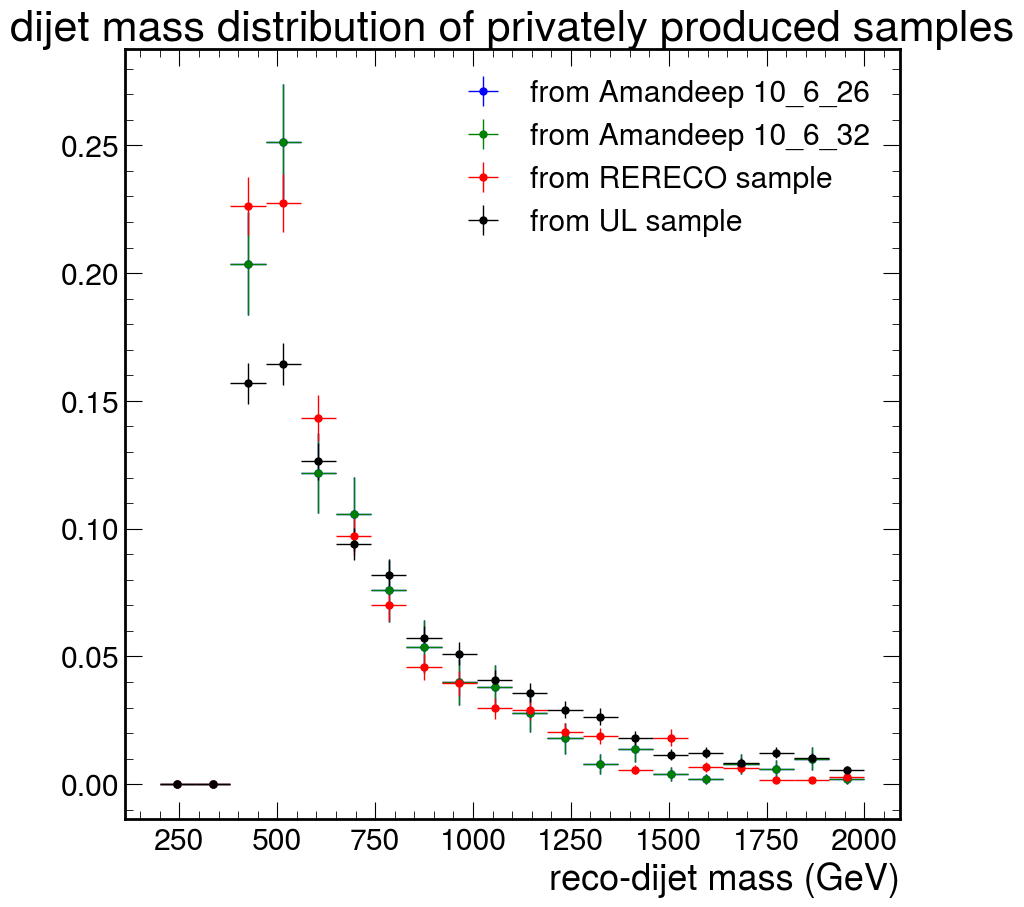

In [19]:
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)
import numpy as np

def getHist(value, binning):
    weights = ak.ones_like(value)
    weights = weights / ak.sum(weights)
    hist, edges = np.histogram(value, bins=binning, weights=weights)
    hist_w2, edges = np.histogram(value, bins=binning, weights=weights*weights)
    return hist, hist_w2

binning_map = {
    "gjj_mass" : [200, 1200, 21],
    "jj_mass" : [200, 2000, 21],
    # "jj_mass" : [200, 1200, 21],
    "jj_dEta" : [0, 9, 21],
}
fig, ax_main = plt.subplots()
binning = np.linspace(*binning_map["jj_mass"])

jj_mass_26, jj_mass_26_w2 = getHist(dijet_26.mass, binning)
jj_mass_32, jj_mass_32_w2 = getHist(dijet_32.mass, binning)
jj_mass_rereco, jj_mass_rereco_w2 = getHist(dijet_rereco.mass, binning)
jj_mass_UL, jj_mass_UL_w2 = getHist(dijet_UL.mass, binning)
# jj_mass_32, edges = np.histogram(dijet_32.mass, bins=binning, weights=)
# jj_mass_rereco, edges = np.histogram(dijet_rereco.mass, bins=binning, weights=)


    
hep.histplot(jj_mass_26, bins=binning, 
         histtype='errorbar', 
        label="from Amandeep 10_6_26", 
         xerr=True, 
         yerr=np.sqrt(jj_mass_26_w2),
        color = "blue",
        ax=ax_main
)
hep.histplot(jj_mass_32, bins=binning, 
         histtype='errorbar', 
        label="from Amandeep 10_6_32", 
         xerr=True, 
         yerr=np.sqrt(jj_mass_32_w2),
        color = "green",
        ax=ax_main
)
hep.histplot(jj_mass_rereco, bins=binning, 
         histtype='errorbar', 
        label="from RERECO sample", 
         xerr=True, 
         yerr=np.sqrt(jj_mass_rereco_w2),
        color = "red",
        ax=ax_main
)
hep.histplot(jj_mass_UL, bins=binning, 
         histtype='errorbar', 
        label="from UL sample", 
         xerr=True, 
         yerr=np.sqrt(jj_mass_UL_w2),
        color = "black",
        ax=ax_main
)

ax_main.set_xlabel("reco-dijet mass (GeV)")
plt.title(f"dijet mass distribution of privately produced samples")
plt.legend(loc="upper right")
plt.show()

In [51]:
print(np.sum(jj_mass_32))
print(np.sum(jj_mass_rereco))
print(np.sum(jj_mass_UL))

0.0013939534546807408
0.0014100789558142424
0.0010428006062284112
